In [1]:
import os
#print(os.listdir("../input"))

import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import re
import collections
 
try:
    from collections import OrderedDict
except ImportError:
    OrderedDict = dict

In [2]:
#read data
df_is_comments= pd.read_csv ("C:/Garima/AI/AIBugTriaging/csvdata/issue_comment.csv", encoding ='latin1') 
df_is= pd.read_csv ("C:/Garima/AI/AIBugTriaging/csvdata/issue.csv", encoding ='latin1') 
df_is_comp= pd.read_csv ("C:/Garima/AI/AIBugTriaging/csvdata/issue_component.csv", encoding ='latin1')

df_is_comments= df_is_comments[["issue_id","message"]]

#Concatenate issue comments message along the issue id
df_is_comments=df_is_comments.groupby('issue_id')['message'].apply(' '.join).reset_index()
print(df_is_comments.head())
df_is =df_is[['issue_id','summary','description']]
df_is['summary']=df_is['summary'] + ' ' + df_is['description']
df_is =df_is[['issue_id','summary']]
df_is_wth_comp=pd.merge(df_is,df_is_comp,on="issue_id")
df_is_wth_comm= pd.merge(df_is_wth_comp, df_is_comments, on="issue_id")


   issue_id                                            message
0     MRM-1               fixed in svn, will deploy very soon.
1    MRM-10                               no longer in Archiva
2   MRM-100  This is already a plexus objject... just need ...
3  MRM-1000  Committed in r713649.\r\n\r\nThanks Martin for...
4  MRM-1001  There is some discussion on dev@continuum abou...


In [3]:
 print("***Count NaN in each column of a DataFrame with comp***")

print("Nan in each columns" , df_is_wth_comp.isnull().sum(), sep='\n')

 print("***Count NaN in each column of a DataFrame with comp and comments***")

print("Nan in each columns" , df_is_wth_comm.isnull().sum(), sep='\n')

***Count NaN in each column of a DataFrame with comp***
Nan in each columns
issue_id       0
summary      231
component      0
dtype: int64
***Count NaN in each column of a DataFrame with comp and comments***
Nan in each columns
issue_id       0
summary      171
component      0
message        0
dtype: int64


In [4]:
#Make data ready by concatenating and selecting required columns also copy data in csv'
df_is_wth_commf=df_is_wth_comm
df_is_wth_commf['summary']=df_is_wth_commf['summary'] + df_is_wth_commf['message']
df_is_wth_commf =df_is_wth_commf[['issue_id','component','summary']]
df_is_wth_comm.to_csv('C:/Garima/AI/AIBugTriaging/csvdata/df_is_wth_comm.csv')

In [5]:
len(df_is_wth_comm)

1227

In [6]:
print(df_is_wth_comm.shape)
df_is_wth_comm.head(5).T

(1227, 4)


,0,1,2,3,4
issue_id,MRM-402,MRM-493,MRM-452,MRM-433,MRM-420
summary,javadoc jar is listed as just jar in the downl...,Downloaded artifacts are stored in incorrect a...,repository purge consumer should check that it...,NaN,Editing a network proxy creates a new network ...
component,Web Interface,remote proxy,repository scanning,repository interface,remote proxy
message,Attached image of what happens.\r\n\r\nThe lis...,MRM-518 has been marked as a duplicate of this...,"this may not be a major issue, since the datab...",It doesn't seem possible to access artifacts w...,"The attribute ""disabled"" of the proxy.id input..."


In [7]:
#Data exploration
df_is_wth_commf = df_is_wth_commf[df_is_wth_commf['summary'].notna()].reset_index(drop=True)
print("***Count NaN in each column of a DataFrame with comp and comments***")

print("Nan in each columns" , df_is_wth_commf.isnull().sum(), sep='\n')

#Drop some of the categories
indexNames = df_is_wth_commf[ (df_is_wth_commf['component'] == 'Selenium tests') | (df_is_wth_commf['component'] == 'Audit Logging') | (df_is_wth_commf['component'] == 'Problem Reporting')
                            | (df_is_wth_commf['component'] == 'Repository Statistics')].index

df_is_wth_commf.drop(indexNames , inplace=True)
df_is_wth_commf.reset_index(inplace=True)
len(df_is_wth_commf)

***Count NaN in each column of a DataFrame with comp and comments***
Nan in each columns
issue_id     0
component    0
summary      0
dtype: int64


1044

In [8]:
df_is_wth_commf.head(5).T

,0,1,2,3,4
index,0,1,2,3,4
issue_id,MRM-402,MRM-493,MRM-452,MRM-420,MRM-420
component,Web Interface,remote proxy,repository scanning,remote proxy,Web Interface
summary,javadoc jar is listed as just jar in the downl...,Downloaded artifacts are stored in incorrect a...,repository purge consumer should check that it...,Editing a network proxy creates a new network ...,Editing a network proxy creates a new network ...


In [9]:
#Data exploration continued
pd.DataFrame(df_is_wth_commf.component.unique())

,0
0,Web Interface
1,remote proxy
2,repository scanning
3,Documentation
4,WebDAV Interface
5,indexing
6,repository interface
7,browser
8,scheduling
9,Users/Security


In [10]:
#combine component types
df_is_wth_commf.replace({'component': 
             {'browser': 'browser and search',
              'search' : 'browser and search',
              'indexing' : 'browser and search',
              'Design' : 'system',
              'scheduling' : 'system',
              'Maven 2 Support' : 'others',
              'redback' : 'others',
              'WebDAV Interface' : 'web',
              'Metadata Repository' : 'repository',
              'repository converter' : 'repository',
              'repository interface' : 'repository',
              'repository scanning' : 'repository',
              'rest services' : 'web',
              'Web Interface' : 'web',
              'reporting' : 'reporting and logging',
              }},inplace= True)

In [11]:
#Data exploration continued
pd.DataFrame(df_is_wth_commf.component.unique())

,0
0,web
1,remote proxy
2,repository
3,Documentation
4,browser and search
5,system
6,Users/Security
7,Build
8,others
9,reporting and logging


In [12]:
# Create a new column 'category_id' with encoded categories 
df_is_wth_commf['category_id'] = df_is_wth_commf['component'].factorize()[0]
category_id_df = df_is_wth_commf[['component', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'component']].values)

# New dataframe
df_is_wth_commf.head()

,index,issue_id,component,summary,category_id
0,0,MRM-402,web,javadoc jar is listed as just jar in the downl...,0
1,1,MRM-493,remote proxy,Downloaded artifacts are stored in incorrect a...,1
2,2,MRM-452,repository,repository purge consumer should check that it...,2
3,3,MRM-420,remote proxy,Editing a network proxy creates a new network ...,1
4,4,MRM-420,web,Editing a network proxy creates a new network ...,0


In [13]:
print(category_to_id)
print(id_to_category)

{'web': 0, 'remote proxy': 1, 'repository': 2, 'Documentation': 3, 'browser and search': 4, 'system': 5, 'Users/Security': 6, 'Build': 7, 'others': 8, 'reporting and logging': 9}
{0: 'web', 1: 'remote proxy', 2: 'repository', 3: 'Documentation', 4: 'browser and search', 5: 'system', 6: 'Users/Security', 7: 'Build', 8: 'others', 9: 'reporting and logging'}


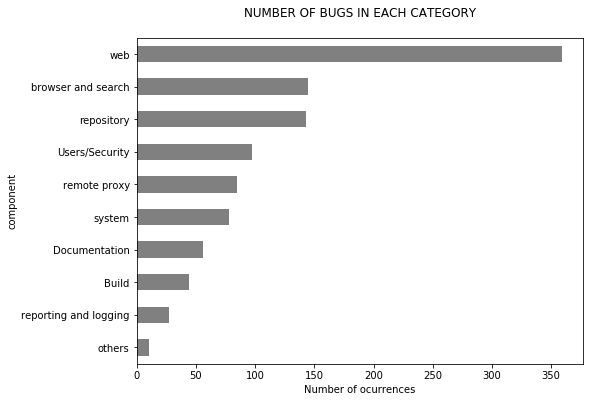

In [14]:
#number of entries per category
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df_is_wth_commf.groupby('component').category_id.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF BUGS IN EACH CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [15]:
#clean data
data = df_is_wth_commf.summary.values.tolist()
data = [re.sub("^https?:\/\/.*[\r\n]*", " ", str(sent)) for sent in data]
data = [re.sub(r'\s+', ' ', str(sent)) for sent in data]
#data = [re.sub("\'", "", str(sent)) for sent in data]
#remove all non alpha numeric characters
#data = [re.sub("[^a-zA-Z0-9 -]", " ", str(sent)) for sent in data]
#find multiple occurence of a dinle character in a string, or look at regx table
#data = [re.sub("\w+(\_|\.)\w+", " ", str(sent)) for sent in data]
data = [re.sub("[^a-zA-Z]", " ", str(sent)) for sent in data]
#replace multiple white spaces
data = [re.sub("/\s\s+/g", " ", str(sent)) for sent in data]



In [16]:
df_data= pd.DataFrame(data, columns =['description'])
len(df_data)


1044

In [17]:
df_data= pd.concat([df_is_wth_commf,df_data], axis=1)
df_data.to_csv("C:/Garima/AI/AIBugTriaging/csvdata/test.csv")
#df_data = df_data[df_data['description'].notna()].reset_index(drop=True)
len(df_data)

1044

In [18]:
len(df_is_wth_commf)

1044

In [19]:
df_data=df_data[['component','category_id','description']]
#df_data.head()
print("Nan in each columns" , df_data.isnull().sum(), sep='\n')

Nan in each columns
component      0
category_id    0
description    0
dtype: int64


In [20]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each dexcription into a vector
features = tfidf.fit_transform(df_data.description).toarray()

labels = df_data.category_id

print("Each of the %d bugs is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 1044 bugs is represented by 4794 features (TF-IDF score of unigrams and bigrams)


In [21]:
# Finding the three most correlated terms with each of the component categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Build:
  * Most Correlated Unigrams are: surefire, launcher, assembly
  * Most Correlated Bigrams are: archiva consumer, committed thanks, assembly plugin

==> Documentation:
  * Most Correlated Unigrams are: site, screenshots, documentation
  * Most Correlated Bigrams are: update documentation, archiva apache, archiva site

==> Users/Security:
  * Most Correlated Unigrams are: roles, redback, ldap
  * Most Correlated Bigrams are: ldap users, security properties, using ldap

==> browser and search:
  * Most Correlated Unigrams are: indexing, index, indexer
  * Most Correlated Bigrams are: apache lucene, nexus index, nexus indexer

==> others:
  * Most Correlated Unigrams are: managedrepositorycontent, artifactreference, calls
  * Most Correlated Bigrams are: code error, maven use, artifact types

==> remote proxy:
  * Most Correlated Unigrams are: defaultrepositoryproxyconnectors, remote, proxy
  * Most Correlated Bigrams are: proxy defaultrepositoryproxyconnectors, wagon http, ar

In [23]:
#Spliting the data into train and test sets
X = df_data['description'] # Collection of documents
y = df_data['component'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

#model evaluation
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df_data.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [25]:
#Merge the predicted result into actual dataframe
df= pd.DataFrame(columns =['y'], index=indices_test)
df['y']=y_pred
df1= pd.DataFrame(columns =['y0'], index=indices_train)
df1['y']=y_train
df_result= pd.concat([df,df1])
df_result = df_result[['y']]
df_result= pd.concat([df_result,df_data],axis=1)
df_result=df_result[['description','category_id','y']]
df_result= pd.concat([df_is_wth_commf,df_result],axis=1)
df_result=df_result[['issue_id','component','description','category_id','y']]
df_result.to_csv("C:/Garima/AI/AIBugTriaging/csvdata/results.csv")
df_result.head()

C:\Users\gtewa\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


,issue_id,component,description,category_id,category_id,y
0,MRM-402,web,javadoc jar is listed as just jar in the downl...,0,0,0
1,MRM-493,remote proxy,Downloaded artifacts are stored in incorrect a...,1,1,1
2,MRM-452,repository,repository purge consumer should check that it...,2,2,2
3,MRM-420,remote proxy,Editing a network proxy creates a new network ...,1,1,0
4,MRM-420,web,Editing a network proxy creates a new network ...,0,0,0


In [26]:
y_predtrain = model.predict(X_train)

In [27]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_train, y_predtrain, 
                                    target_names= df_data['component'].unique()))

				CLASSIFICATIION METRICS

                       precision    recall  f1-score   support

                  web       0.94      0.96      0.95       272
         remote proxy       0.95      0.93      0.94        58
           repository       0.93      0.94      0.94       105
        Documentation       0.96      0.94      0.95        49
   browser and search       0.95      0.95      0.95       112
               system       0.94      0.87      0.91        55
       Users/Security       0.88      0.94      0.91        71
                Build       0.94      0.91      0.93        34
               others       1.00      0.57      0.73         7
reporting and logging       1.00      0.95      0.97        20

          avg / total       0.94      0.94      0.94       783



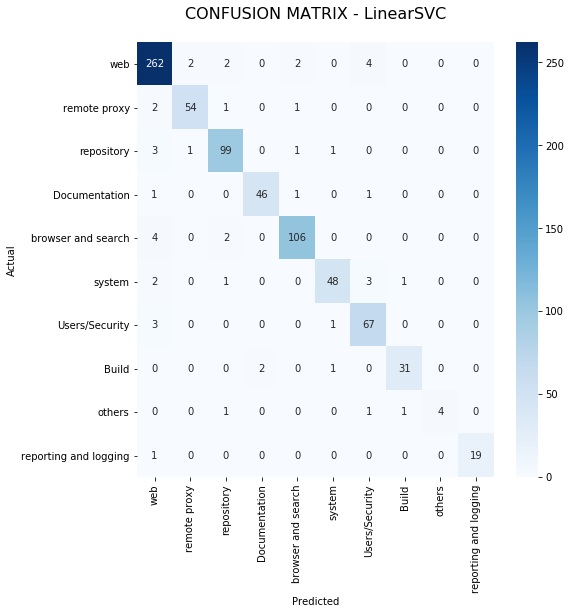

In [28]:
#confusion matrix
conf_mat = confusion_matrix(y_train, y_predtrain)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.component.values, 
            yticklabels=category_id_df.component.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [29]:
#most correlated term with each category
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Build':
  * Top unigrams: windows, resources, license, assembly
  * Top bigrams: assembly plugin, archiva common, maven plugin, committed thanks

==> 'Documentation':
  * Top unigrams: documentation, site, guide, screenshots
  * Top bigrams: archiva site, archiva apache, update documentation, apache org

==> 'Users/Security':
  * Top unigrams: redback, ldap, user, users
  * Top bigrams: global repository, account locked, archiva security, using ldap

==> 'browser and search':
  * Top unigrams: indexer, index, search, indexing
  * Top bigrams: search results, dependency graph, browse repository, archiva browse

==> 'others':
  * Top unigrams: profile, model, failed, extensions
  * Top bigrams: archiva redback, applied branch, maven shared, maven use

==> 'remote proxy':
  * Top unigrams: proxy, remote, proxying, defaultrepositoryproxyconnectors
  * Top bigrams: wagon http, archiva proxy, plugin maven, remote repositories

==> 'reporting and logging':
  * Top unigrams: reports, rep